# 1. Train test split

In [1]:
import sys
sys.path.append('../../')
import pandas as pd
from SynTemp.SynUtils.utils import load_database, save_database, train_val_test_split_df
data = pd.DataFrame(load_database('../../Data/DPO/USPTO_50K/USPTO_50K_aam_reactions.json.gz'))
original_data = pd.read_csv('../../Data/USPTO_50K/USPTO_50K_original.csv')

data = pd.concat([data, original_data['class']], axis=1)

In [2]:
train_df, val_df, test_df = train_val_test_split_df(data, target='class', random_state=42)

In [3]:
train_df.shape

(40012, 6)

In [77]:
train_df, val_df, test_df = train_val_test_split_df(data, target='class', random_state=42)

save_database(train_df.to_dict('records'), '../../Data/DPO/USPTO_50K/train.json.gz')
save_database(val_df.to_dict('records'), '../../Data/DPO/USPTO_50K/val.json.gz')
save_database(test_df.to_dict('records'), '../../Data/DPO/USPTO_50K/test.json.gz')

# 2. Rules Writing

In [3]:
#folder_name = 'Non_hydrogen'
folder_name = 'Good_hydrogen'
#folder_name = 'Hydrogen'

In [4]:
import sys
sys.path.append('../../')
from SynTemp.SynUtils.utils import load_from_pickle, save_to_pickle
from SynTemp.SynUtils.graph_utils import add_child_ids 
temp = load_from_pickle(f'../../Data/DPO/USPTO_50K/{folder_name}/templates.pkl.gz')
processed_data = add_child_ids(temp)
save_to_pickle(processed_data, f'../../Data/DPO/USPTO_50K/{folder_name}/hier_rules.pkl.gz')

In [ ]:
non_h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Non_hydrogen/templates.pkl.gz')
h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Hydrogen/templates.pkl.gz')
good_h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Good_hydrogen/templates.pkl.gz')

In [ ]:
from SynTemp.SynUtils.graph_utils import check_graph_type, get_cycle_member_rings
for value in temp[0]:
    value["Reaction Type"] = check_graph_type(value["RC"][2])
    value["Rings"] = get_cycle_member_rings(value["RC"][2])


In [ ]:
from SynTemp.SynRule.rule_writing import RuleWriting
for i in range(4):
    templates = temp[i]
    if folder_name == 'Good_hydrogen':
        if i == 0:
            templates = [value for value in templates if value['Reaction Type'] in ['Single Cyclic', 'Complex Cyclic']]
            parent_id = [value['Cluster_id'] for value in templates]
        else:
            templates = [value for value in templates if value['Parent'] in parent_id]
            print(len(templates))
            parent_id = [value['Cluster_id'] for value in templates]
    
    rules = RuleWriting.auto_extraction(data_dicts=templates, id_column=f'Cluster_id', rule_column = 'RC', reindex=True,
                                        save_path=f'../../Data/DPO/USPTO_50K/{folder_name}/R{i}/'
                                        )


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 149 out of 149 | elapsed:    1.1s finished


1081


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1081 out of 1081 | elapsed:    0.1s finished


7668


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 328 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 7668 out of 7668 | elapsed:    1.2s finished


18350


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 18350 out of 18350 | elapsed:    3.3s finished


In [ ]:
all = [{'R0':285, 'R1': 1512, 'R2':9709, 'R3':22280},
       {'R0':266, 'R1': 1465, 'R2':9591, 'R3':22131},
       {'R0':149, 'R1': 1081, 'R2':7668, 'R3':18350}]

In [ ]:
import pandas as pd
pd.DataFrame(all)

,R0,R1,R2,R3
0,285,1512,9709,22280
1,266,1465,9591,22131
2,149,1081,7668,18350


## Templates analysis

In [4]:
import sys
sys.path.append('../../')
from SynTemp.SynUtils.utils import load_from_pickle, save_to_pickle
cluster = load_from_pickle('../../Data/DPO/USPTO_50K/Good_hydrogen/cluster.pkl.gz')

In [5]:
len(cluster)

34584

/tmp/ipykernel_418649/4132136174.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ids[:num_bars], rotation=45)


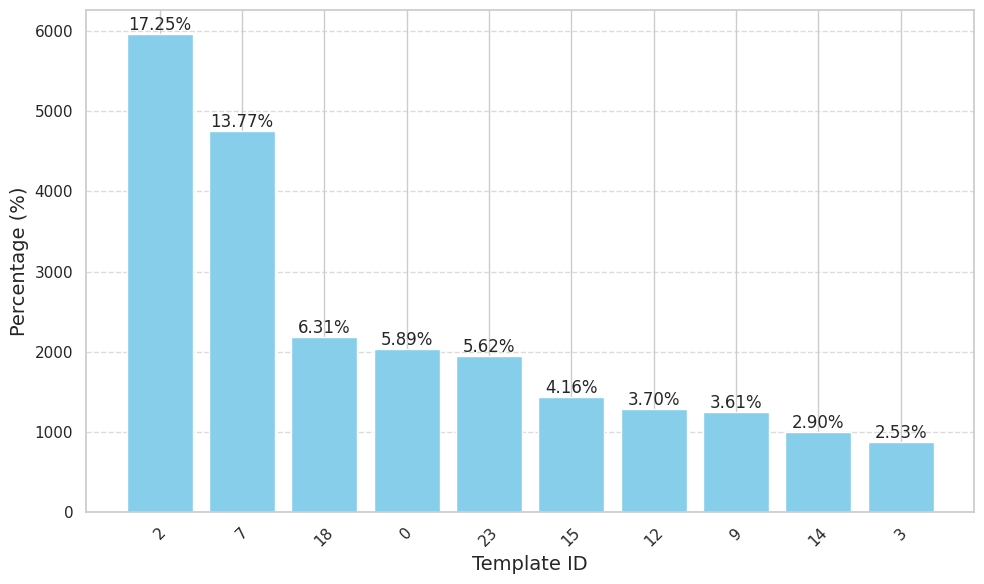

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

template_ids = [value['Cluster_R0'] for value in cluster]
max_template = len(template_ids)

count_dict = Counter(template_ids)
sorted_counts = count_dict.most_common()

ids = [str(item[0]) for item in sorted_counts]
counts = [item[1] for item in sorted_counts]

num_bars = 10

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(ids[:num_bars], counts[:num_bars], color='skyblue')

for bar in bars:
    yval = bar.get_height()
    percent = yval / max_template * 100
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{percent:.2f}%', ha='center', va='bottom')

ax.set_xlabel('Template ID', fontsize =14)
ax.set_ylabel('Percentage (%)', fontsize =14)
# ax.set_title('Top 10 Most Common Template IDs')
ax.set_xticklabels(ids[:num_bars], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./fig/Templates_distribution.pdf', dpi=600)
plt.show()


## ITS reaction type analysis

In [20]:
h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Hydrogen/templates.pkl.gz')
for value in h[0]:
    value["Reaction Type"] = check_graph_type(value["RC"][2])
    value["Rings"] = get_cycle_member_rings(value["RC"][2])

In [22]:
temp_h0 = h[0]

In [26]:
pd.DataFrame(h[0])['Reaction Type'].value_counts()

Reaction Type
Single Cyclic     119
Acyclic            60
None               57
Complex Cyclic     30
Name: count, dtype: int64

## ITS ring analysis

In [5]:
from SynTemp.SynUtils.graph_utils import check_graph_type, get_cycle_member_rings
good_h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Good_hydrogen/templates.pkl.gz')
for value in good_h[0]:
    value["Reaction Type"] = check_graph_type(value["RC"][2])
    value["Rings"] = get_cycle_member_rings(value["RC"][2])

temp_0 = [value for value in good_h[0] if value['Reaction Type'] in ['Single Cyclic', 'Complex Cyclic']]

In [ ]:
good_h = load_from_pickle(f'../../Data/DPO/USPTO_50K/Hydrogen/templates.pkl.gz')
for value in good_h[0]:
    value["Reaction Type"] = check_graph_type(value["RC"][2])
    value["Rings"] = get_cycle_member_rings(value["RC"][2])

In [6]:
single = [value for value in good_h[0] if value['Reaction Type'] in ['Single Cyclic']]
complex = [value for value in good_h[0] if value['Reaction Type'] in ['Complex Cyclic']]

/tmp/ipykernel_418649/1071625.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=single_types_of_rings, y=single_percentages, palette='coolwarm')
/tmp/ipykernel_418649/1071625.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=complex_types_of_rings, y=complex_percentages, palette='coolwarm')
/tmp/ipykernel_418649/1071625.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")


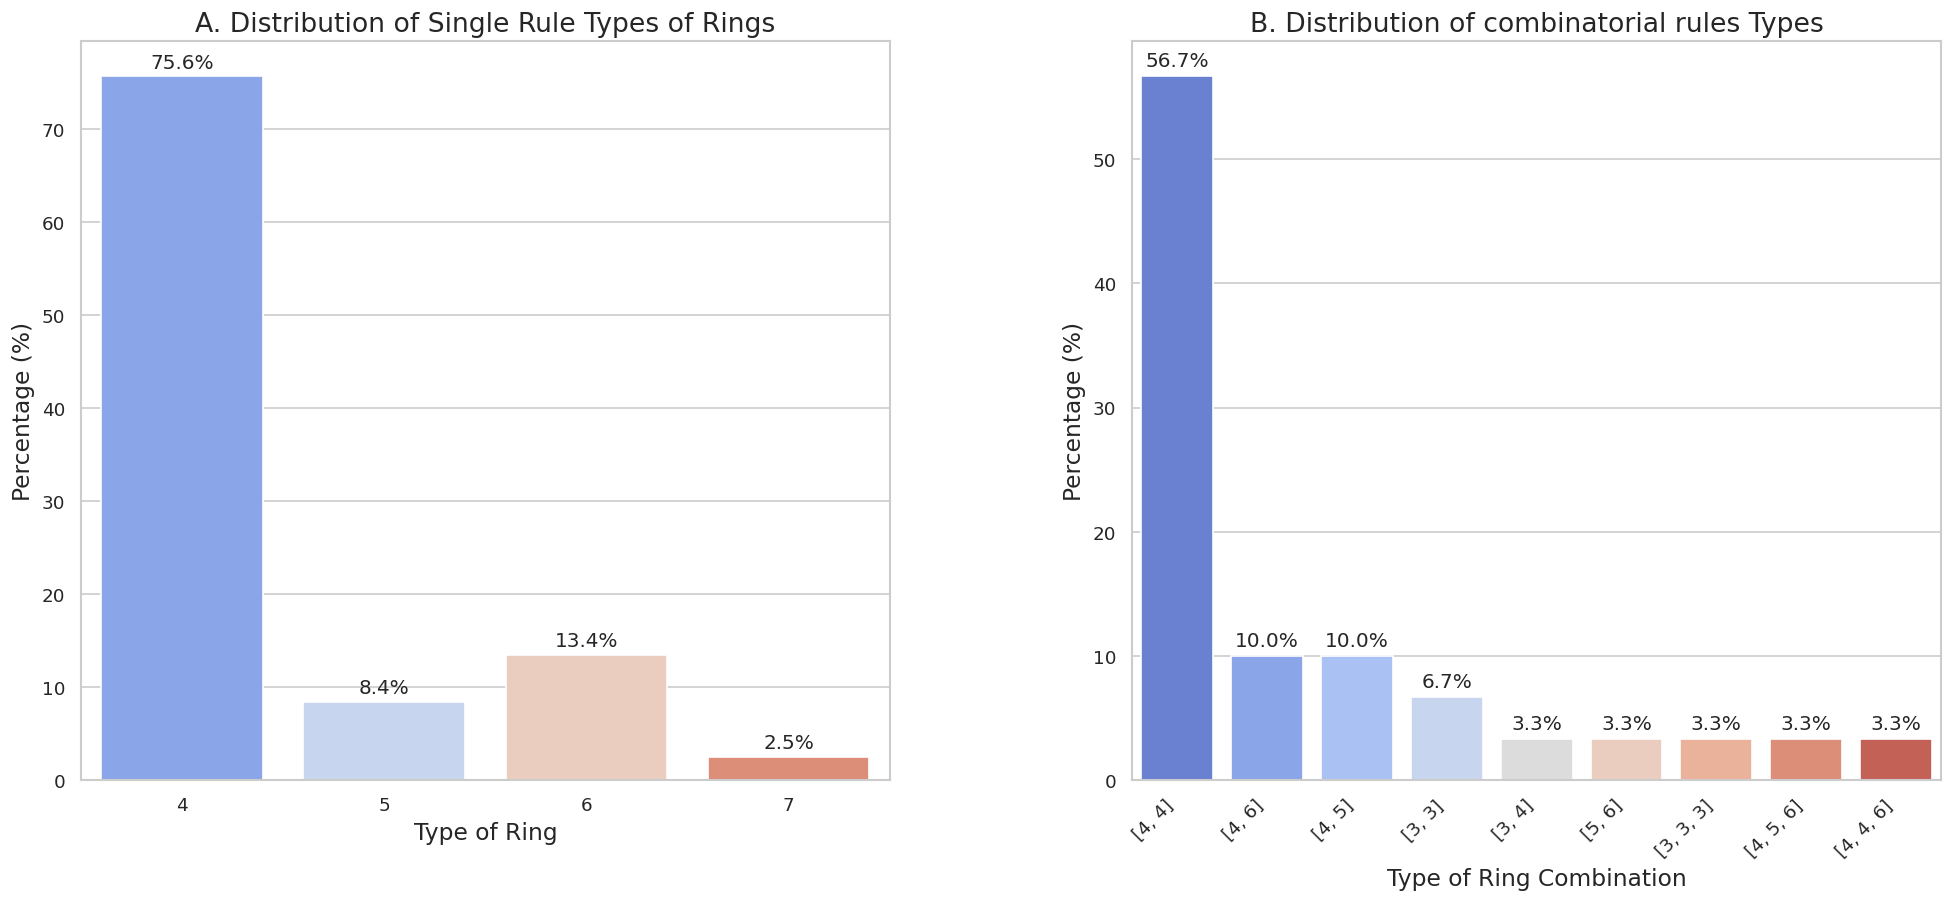

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for single rules
single_rules = {
    4: 90,
    5: 10,
    6: 16,
    7: 3
}

# Data for complex rules
complex_rules = {
    '[4, 4]': 17,
    '[4, 6]': 3,
    '[4, 5]': 3,
    '[3, 3]': 2,
    '[3, 4]': 1,
    '[5, 6]': 1,
    '[3, 3, 3]': 1,
    '[4, 5, 6]': 1,
    '[4, 4, 6]': 1,  
}

# Calculate total counts for single and complex rules
total_single = sum(single_rules.values())
total_complex = sum(complex_rules.values())

# Convert counts to percentages
single_percentages = [value / total_single * 100 for value in single_rules.values()]
complex_percentages = [value / total_complex * 100 for value in complex_rules.values()]

# Extract keys for plotting
single_types_of_rings = list(single_rules.keys())
complex_types_of_rings = list(complex_rules.keys())

# Set style
sns.set(style="whitegrid")

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=120)
fig.subplots_adjust(wspace=0.3)

# Plot for single rules
sns.barplot(ax=axes[0], x=single_types_of_rings, y=single_percentages, palette='coolwarm')
axes[0].set_title('A. Distribution of Single Rule Types of Rings', fontsize=16)
axes[0].set_xlabel('Type of Ring', fontsize=14)
axes[0].set_ylabel('Percentage (%)', fontsize=14)
for index, value in enumerate(single_percentages):
    axes[0].text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=12)

# Plot for complex rules
sns.barplot(ax=axes[1], x=complex_types_of_rings, y=complex_percentages, palette='coolwarm')
axes[1].set_title('B. Distribution of combinatorial rules Types', fontsize=16)
axes[1].set_xlabel('Type of Ring Combination', fontsize=14)
axes[1].set_ylabel('Percentage (%)', fontsize=14)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
for index, value in enumerate(complex_percentages):
    axes[1].text(index, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=12)
plt.savefig('./fig/rules_ring.pdf', dpi=600)
plt.show()